In [3]:
#!pip install neo4j
#!pip install surprise
import pandas as pd
import numpy as np
from neo4j import GraphDatabase
import graph_model as gm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import KNNBaseline
from surprise import SVDpp
from surprise import CoClustering
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

# Model Tuning and Testing #

This file contains the final cross validation results for all of the reccomendation systems I experimented with. The results of previous hyperparamter searches are in the cv_results folder. The models were tuned used cross validiton on a few states, mostly Pennsylvainia, Ohio and Illinois.  I then used Quebec as the test set, so none of the models were tuned on this data.

This first section is grabbing the Quebec data from the server and making sure we have it all.

In [4]:
uri = "bolt://54.145.141.152:7687"''
driver = GraphDatabase.driver(uri, auth=("neo4j", "i-0e23d19f0d8795714"))

result = gm.cypher(driver,'\
    MATCH (u:User)-->(r:Review)-->(b:Business)-->(:City)-->(s:State {name:"QC"})\
    RETURN u.id, r.stars, b.id', ["userID", "rating", "itemID"])

QC_reviewsdf = result
QC_reviewsdf.head()

,userID,rating,itemID
0,pv6iucL4vcT4Bm69nd477g,1.0,Wrpf3g5EUyuWbf-ey9aQ_A
1,d-lhIwhk_9cDGSzF6ZQ-SA,1.0,Wrpf3g5EUyuWbf-ey9aQ_A
2,JFt7m1ZtnWhX2dQNZGmvQw,3.0,Wrpf3g5EUyuWbf-ey9aQ_A
3,8apKnC2iVfWnfB4cIgUBMw,3.0,Wrpf3g5EUyuWbf-ey9aQ_A
4,ZRYqMyXtb-kmHIhDrRdI0Q,4.0,5mVE0xEy9NfMdkhliPh8IQ


In [ ]:
QC_reviewsdf.to_csv('Q')

In [6]:
QC_reviewsdf.shape

(178971, 3)

In [7]:
QC_reviewsdf.nunique()

userID    52738
rating        5
itemID     9210
dtype: int64

In [10]:
#Now we put the data into a dataset object for use by the surprise package testing methods
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(QC_reviewsdf[['userID', 'itemID', 'rating']], reader)

# for the graph model we have to take a random sample of businesses to test. The rest of the businesses are potentially
#used in the calculating predicted reviews.
test_sample = QC_reviewsdf.sample(4000)


## Testing the Graph Model ##

In [12]:
test_sample['prediction'] = [gm.graph_model_predict(driver, x , y) for x,y in zip(test_sample['userID'], test_sample['itemID'])]
test_sample['error'] = test_sample.rating-test_sample.prediction

rms = pow(mean_squared_error(test_sample.rating, test_sample.prediction), .5)
mae = mean_absolute_error(test_sample.rating, test_sample.prediction)
rms,mae

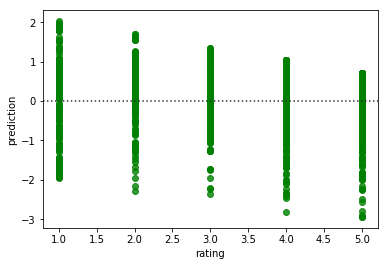

In [20]:
sns.residplot(test_sample.rating, test_sample.prediction, color="g")

Evaluation of prediciton models: SVDpp, Coclustering, and KNN with baseline esitamates both user and item focused. We also investigate the effectiveness of ensembling these methods and taking an mean and median average. 

In [8]:
coclu=CoClustering(n_cltr_u=2, n_cltr_i=6, n_epochs=40)


In [9]:
svd=SVDpp(n_factors=15, n_epochs=15, lr_all=.02, reg_all=.2)



In [10]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False,
               'min_support': 10,
               'shrinkage': 50
              }

bsl_options = {'method': 'als',
               'n_epochs': 15,
               'reg_u': 5,
               'reg_i': 2
               }


knn=KNNBaseline(sim_options=sim_options, bsl_options=bsl_options, k=30, min_k=15)


In [11]:
cross_validate(coclu, data, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2510  1.2553  1.2529  1.2613  1.2627  1.2566  0.0046  
MAE (testset)     0.9402  0.9403  0.9395  0.9456  0.9488  0.9429  0.0037  
Fit time          14.19   13.97   14.27   14.21   14.23   14.17   0.10    
Test time         0.32    0.32    0.20    0.32    0.33    0.30    0.05    


{'test_rmse': array([1.2510053 , 1.25525689, 1.25287729, 1.2613098 , 1.26271075]),
 'test_mae': array([0.94023614, 0.94025611, 0.93951462, 0.9455891 , 0.94877878]),
 'fit_time': (14.18798279762268,
  13.974129676818848,
  14.26918888092041,
  14.20827841758728,
  14.228464365005493),
 'test_time': (0.3239619731903076,
  0.3242943286895752,
  0.20160865783691406,
  0.32163500785827637,
  0.32757997512817383)}

In [12]:
cross_validate(svd, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1241  1.1286  1.1265  1.1251  1.1374  1.1284  0.0048  
MAE (testset)     0.8790  0.8812  0.8822  0.8803  0.8886  0.8823  0.0033  
Fit time          44.12   47.11   44.53   44.78   44.97   45.10   1.05    
Test time         1.89    2.03    2.07    2.09    2.00    2.01    0.07    


{'test_rmse': array([1.12414642, 1.12860151, 1.12652921, 1.12507021, 1.13744645]),
 'test_mae': array([0.87896629, 0.88122054, 0.88224494, 0.88031921, 0.88857595]),
 'fit_time': (44.12103247642517,
  47.1144483089447,
  44.52857279777527,
  44.77706813812256,
  44.97261071205139),
 'test_time': (1.8885676860809326,
  2.0316741466522217,
  2.066457509994507,
  2.0894460678100586,
  1.9984714984893799)}

In [13]:
cross_validate(knn, data, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1147  1.1262  1.1238  1.1237  1.1212  1.1219  0.0040  
MAE (testset)     0.8706  0.8790  0.8730  0.8765  0.8733  0.8745  0.0030  
Fit time          5.92    6.00    5.99    6.05    5.98    5.99    0.04    
Test time         1.42    1.40    1.62    1.61    1.6

{'test_rmse': array([1.1146612 , 1.12624527, 1.12378043, 1.12366525, 1.12120049]),
 'test_mae': array([0.87055734, 0.87903172, 0.87297376, 0.87646662, 0.87328342]),
 'fit_time': (5.918645143508911,
  5.99767804145813,
  5.991095781326294,
  6.049122333526611,
  5.979476451873779),
 'test_time': (1.4174723625183105,
  1.3976738452911377,
  1.6226787567138672,
  1.6135437488555908,
  1.6180102825164795)}